# CLEAN BUILD FROM SCRATCH MIT-B2 on patches 768x768

# imports

In [1]:
import random
from pathlib import Path

import numpy as np
import pandas as pd
import cv2 as cv
import os

from matplotlib import pyplot as plt
from glob import glob
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
from IPython.display import clear_output

import albumentations as A
import albumentations.pytorch

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim.swa_utils import AveragedModel, SWALR

import torch.cuda.amp as amp
is_amp = True

In [2]:
!nvidia-smi

Sat Aug 27 10:41:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.152.00   Driver Version: 418.152.00   CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   44C    P0    53W / 300W |  30380MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   44C    P0    54W / 300W |   1905MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

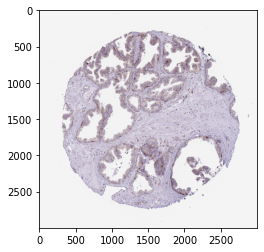

In [3]:
img1 = cv.imread('./../data/train_images/10044.tiff')[:, :, ::-1]
plt.imshow(img1)
plt.show()

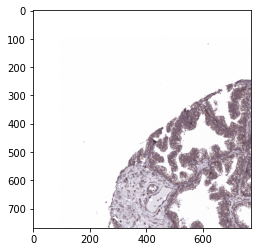

In [5]:
img2 = cv.imread('./../data/train_images_patches_768_overlap_stain_aug/10044_00000_01.png')[:, :, ::-1]
plt.imshow(img2)
plt.show()

# data

In [6]:
ORGAN2ID = {
    'kidney' : 0,
    'prostate' : 1,
    'largeintestine' : 2,
    'spleen' : 3,
    'lung' : 4
}
ID2ORGAN = {v: k for k, v in ORGAN2ID.items()}

# model testing

In [7]:
from model import Net
from mit import *

## data 768

In [8]:
TRAIN_CSV = './../data/train.csv'
TEST_CSV = './../data/test.csv'
TRAIN_IMAGES_DIR = './../data/train_images_patches_768_overlap_stain_aug/'
TRAIN_MASKS_DIR = './../data/train_masks_patches_768_overlap_stain_aug/'

N_CROSS_VALID_SPLITS = 5
RANDOM_SEED = 2022

SPATIAL_SIZE = 768 # размер патча


In [9]:
train_df = pd.read_csv(TRAIN_CSV)

In [10]:
def make_train_image_path(row):
    return os.path.join(TRAIN_IMAGES_DIR, str(row['id']) + '.png')

def make_train_mask_path(row):
    return os.path.join(TRAIN_MASKS_DIR, str(row['id']) + '.png')

def create_folds(df: pd.DataFrame, n_splits: int, random_seed: int) -> pd.DataFrame:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    for fold, (_, val_idx) in enumerate(skf.split(X=df, y=df["organ"])):
        df.loc[val_idx, "fold"] = int(fold)

    return df

In [11]:
train_df = create_folds(train_df, n_splits=N_CROSS_VALID_SPLITS, random_seed=RANDOM_SEED)

In [12]:
train_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,fold
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,4.0
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,0.0
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,0.0
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,0.0
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,4.0


In [13]:
def make_768_dataset(df):
    new_df = []
    for index, row in df.iterrows():
        id = row['id']
        glb = list(glob(TRAIN_IMAGES_DIR + '{}_*.png'.format(id)))
        for fname in glb:
            newrow = dict()
            newrow['id'] = id
            newrow['image'] = fname
            newrow['mask'] = fname.replace('train_images_', 'train_masks_')
            newrow['organ'] = row['organ']
            newrow['pixel_size'] = row['pixel_size']
            newrow['fold'] = row['fold']
            
            new_df.append(newrow)
    return pd.DataFrame(new_df)

In [14]:
train_df_768 = make_768_dataset(train_df)
print(train_df_768.shape)
train_df_768.head()

(95238, 6)


,fold,id,image,mask,organ,pixel_size
0,4.0,10044,./../data/train_images_patches_768_overlap_sta...,./../data/train_masks_patches_768_overlap_stai...,prostate,0.4
1,4.0,10044,./../data/train_images_patches_768_overlap_sta...,./../data/train_masks_patches_768_overlap_stai...,prostate,0.4
2,4.0,10044,./../data/train_images_patches_768_overlap_sta...,./../data/train_masks_patches_768_overlap_stai...,prostate,0.4
3,4.0,10044,./../data/train_images_patches_768_overlap_sta...,./../data/train_masks_patches_768_overlap_stai...,prostate,0.4
4,4.0,10044,./../data/train_images_patches_768_overlap_sta...,./../data/train_masks_patches_768_overlap_stai...,prostate,0.4


In [15]:
train_df_768 = train_df_768.sample(5000)

In [16]:
train_df_768.iloc[0]['image']

'./../data/train_images_patches_768_overlap_stain_aug/17422_00004_03.png'

In [17]:
train_df_768.iloc[0]['mask']

'./../data/train_masks_patches_768_overlap_stain_aug/17422_00004_03.png'

In [18]:
train_df_768.iloc[0]['id']

17422

In [19]:
# ---------------------------------------------------------------
# WARNING! THIS RESCALE IS INJECTED IN SWIN TRANSFORMER ALREADY!
#   RGB LAYER
# IT'S INPUTS HAVE TO BE IMAGE IN 0..1!
# ---------------------------------------------------------------

In [20]:
train_transform= A.Compose([
#     A.Resize(512, 512, interpolation=cv.INTER_LINEAR),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.HueSaturationValue(p=0.25),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=(-0.1, 0.5),rotate_limit=90, p=0.5),
    A.ElasticTransform(p=0.1, alpha=90, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    A.GridDistortion(p=0.25),
    A.Blur(blur_limit=5, p=0.1),
    A.GaussNoise(var_limit=(20, 100), p=0.2),
    A.ChannelDropout(p=0.05),
    A.RandomGamma(p=0.1),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], 
                max_pixel_value=255, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [21]:
val_transform = A.Compose([
#     A.Resize(512, 512, interpolation = cv.INTER_LINEAR),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1],
                 max_pixel_value=255, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [22]:
def worker_init_fn(worker_id):
    torch_seed = torch.initial_seed()
    random.seed(torch_seed + worker_id)
    if torch_seed >= 2**30:  # make sure torch_seed + workder_id < 2**32
        torch_seed = torch_seed % 2**30
    np.random.seed(torch_seed + worker_id)
    random.seed(torch_seed + worker_id + 77777)

# model

In [23]:
!nvidia-smi

Sat Aug 27 10:45:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.152.00   Driver Version: 418.152.00   CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-DGXS...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   44C    P0    54W / 300W |  30380MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-DGXS...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   44C    P0    54W / 300W |   1905MiB / 32478MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [24]:
device = 'cuda:2'
DEVICE = device

In [25]:
pretrain_dir = './../mit-b2-segformer-first-try/'

In [26]:
model = Net().to(device)

In [27]:
chkpts = []
for i, fname in enumerate(sorted(glob('./checkpoint_fold_3/mit-b2_ep_*_dice_*.pt'))):
#     print(fname)
    bname = os.path.basename(fname)
    spt = bname.split('_')
    epoch = int(spt[2])
    dice = float(spt[4].rsplit('.', maxsplit=1)[0])
    print(i, '   ', epoch, dice)
    chkpts.append((fname, dice, epoch))

0     0 0.75295
1     1 0.756783
2     20 0.766976
3     21 0.757537
4     22 0.696295
5     23 0.744632
6     24 0.756131
7     25 0.757606
8     26 0.75708
9     27 0.744385
10     28 0.758298
11     29 0.763959
12     30 0.759373
13     31 0.77874
14     32 0.762968
15     33 0.749002
16     34 0.761842
17     35 0.771875
18     36 0.776896
19     37 0.760407
20     38 0.740925
21     39 0.77177
22     40 0.774935
23     41 0.761899
24     42 0.752424
25     43 0.742532
26     44 0.752616
27     45 0.757236
28     46 0.766599
29     47 0.752989
30     48 0.765384
31     49 0.765584
32     50 0.77314
33     51 0.745427
34     52 0.74597
35     53 0.759528
36     54 0.757127
37     55 0.767972
38     56 0.756779
39     57 0.750377
40     58 0.73579
41     59 0.727256
42     60 0.727515
43     61 0.754339
44     62 0.74662
45     63 0.749102
46     64 0.74935
47     65 0.742675
48     66 0.734288
49     67 0.752861
50     68 0.731001
51     69 0.748671


In [25]:
# to_swa_ckpts = chkpts[7:18]

In [30]:
to_swa_ckpts = list(sorted(chkpts, key=lambda x: x[1]))[-3:]

In [31]:
to_swa_ckpts

[('./checkpoint_fold_3/mit-b2_ep_040_dice_0.774935.pt', 0.774935, 40),
 ('./checkpoint_fold_3/mit-b2_ep_036_dice_0.776896.pt', 0.776896, 36),
 ('./checkpoint_fold_3/mit-b2_ep_031_dice_0.778740.pt', 0.77874, 31)]

In [32]:
model.load_state_dict(torch.load(to_swa_ckpts[-1][0], map_location=device), strict=False)

<All keys matched successfully>

In [33]:
swa_model = AveragedModel(model)

In [34]:
for el in tqdm(to_swa_ckpts):
    model.load_state_dict(torch.load(el[0], map_location=device), strict=False)
    swa_model.update_parameters(model)

100%|██████████| 3/3 [00:00<00:00,  4.46it/s]


In [35]:
# model.load_state_dict(torch.load('./checkpoint_fold_3_SAM/mit-b2_ep_501_dice_0.772775.pt', map_location=device))

# don't forget to call this after training

In [36]:
CURRENT_FOLD = 3

In [37]:
# swa_model.load_state_dict(torch.load('..'))

In [38]:
swa_model = swa_model.to(device)

In [39]:
class HubmapDataset768(Dataset):
    def __init__(self, df, transform=None):

        self.df = df
        self.transform = transform
        self.length = len(self.df)

    def __str__(self):
        string = ''
        string += '\tlen = %d\n' % len(self)

        d = self.df.organ.value_counts().to_dict()
        for k in ['kidney', 'prostate', 'largeintestine', 'spleen', 'lung']:
            string +=  '%24s %3d (%0.3f) \n'%(k,d.get(k,0),d.get(k,0)/len(self.df))
        return string

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        if index % 100 == 0:
            print(index)
        d = self.df.iloc[index]
        organ = ORGAN2ID[d['organ']]

        image = cv.cvtColor(cv.imread(d['image']), cv.COLOR_BGR2RGB) # .astype(np.float32) / 255.0
        
        image = self.transform(image=image)['image'].to(device)

        return {'image': image}

In [40]:
val_transform = A.Compose([
#     A.Resize(512, 512, interpolation = cv.INTER_LINEAR),
    A.Normalize(mean=[0, 0, 0], std=[1, 1, 1],
                 max_pixel_value=255, always_apply=True),
    albumentations.pytorch.ToTensorV2()
], p=1)

In [41]:
train_dataset = HubmapDataset768(train_df_768[train_df_768['fold'] != CURRENT_FOLD], val_transform)
loader_params = {'shuffle': True,
                 'num_workers': 0,
                 'worker_init_fn': worker_init_fn}
loader_train = DataLoader(train_dataset, 
                          batch_size=8, 
                          shuffle=False,
                          worker_init_fn=worker_init_fn,
                          num_workers=0
                         )

In [42]:
torch.optim.swa_utils.update_bn(loader_train, swa_model)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000


In [43]:
torch.save(swa_model.state_dict(), os.path.join(
                    '.', #'./checkpoint_fold_{}'.format(CURRENT_FOLD), 
                    'liza_fold3_mitb2_BEST3.pt'
                )) 